First notebook exploring coverage of AIS data.  
Data was extracted from the UN Global Platform (source data is from Spire / Exact Earth)  
#### Coverage: December 2018 - August 2022
#### Ports: Tartus, Baniyas, Al Ladhiqiyah.  
20 km buffer around each port

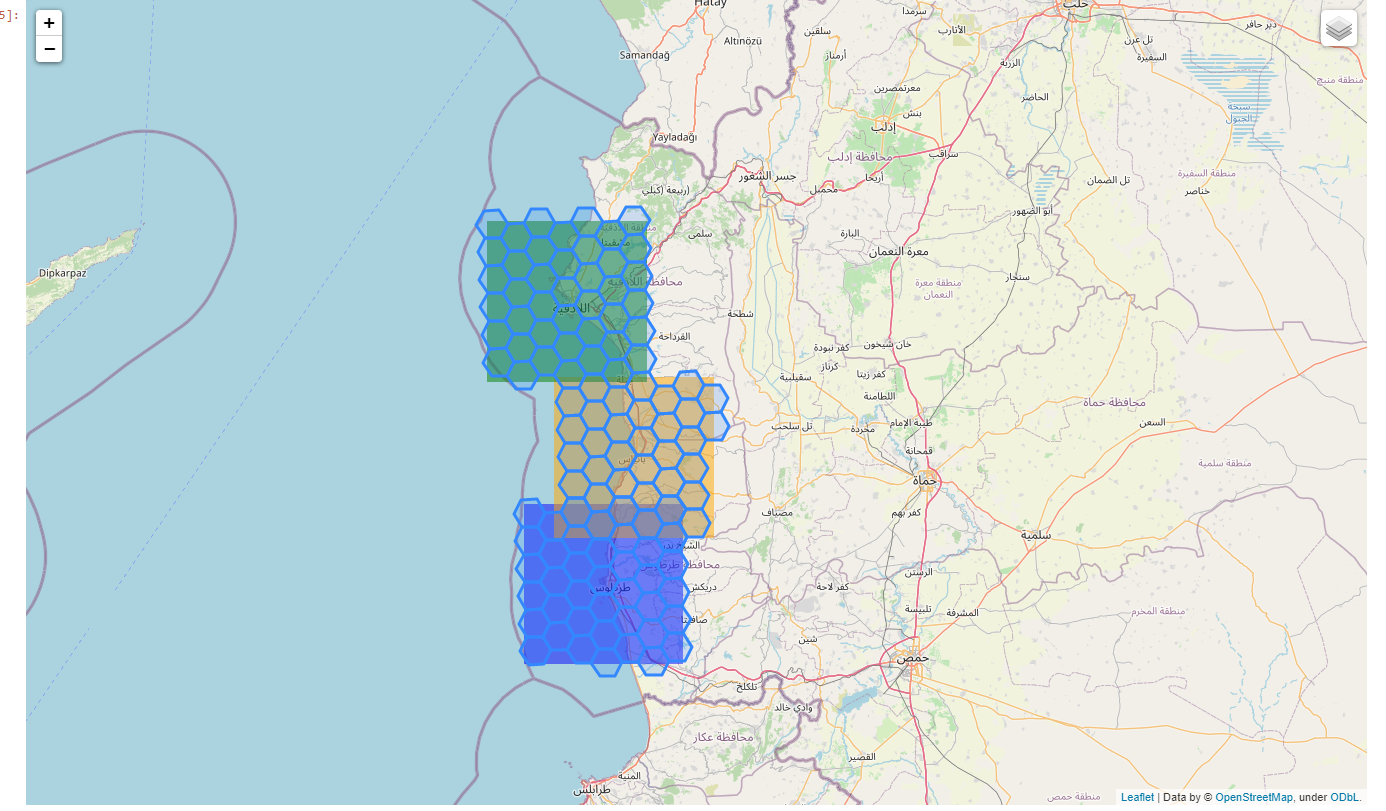

In [1]:
import os
from os.path import join
from glob import glob
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Point
import folium.plugins as plugins
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
pd.options.display.max_columns = None

In [3]:
ais_dir = join(os.path.expanduser("~"), 'data', 'AIS')
data_dir = join(ais_dir, 'Syria')

In [4]:
data_files = glob(data_dir+"/*.csv")

In [5]:
dfs = [pd.read_csv(f, index_col=0) for f in data_files]

In [6]:
df = pd.concat(dfs)

In [8]:
df.head(2)

H3_int_index_6  message_type         mmsi        dt_insert_utc  \
90000  604285236087357439             1  355909000.0  2020-08-31 23:06:45   
90001  604285236087357439             1  355909000.0  2020-08-31 22:11:15   

       longitude   latitude        imo vessel_name callsign vessel_type  \
90000  35.768167  35.518667  9037276.0       BEATA    3FZK3       Cargo   
90001  35.768000  35.518833  9037276.0       BEATA    3FZK3       Cargo   

       vessel_type_code vessel_type_cargo vessel_class  length  width  \
90000               NaN               NaN            A   130.0   18.0   
90001               NaN               NaN            A   130.0   18.0   

      flag_country  flag_code destination        eta  draught  sog    cog  \
90000       Panama        NaN      SY ALD  8271300.0      8.0  0.0  180.0   
90001       Panama        NaN      SY ALD  8271300.0      8.0  0.0   26.0   

       rot  heading              nav_status  nav_status_code source  \
90000  0.0    197.0  Under Way Using Engine              0.0  T-AIS   
90001  0.0    197.0  Under Way Using Engine              0.0  T-AIS   

                dt_pos_utc        dt_static_utc         vessel_type_main  \
90000  2020-08-31 23:06:45  2020-08-31 23:06:45  Oil And Chemical Tanker   
90001  2020-08-31 22:11:15  2020-08-31 22:11:15  Oil And Chemical Tanker   

       vessel_type_sub  eeid  \
90000  Chemical Tanker   NaN   
90001  Chemical Tanker   NaN   

                                         source_filename        H3index_0  \
90000  s3a://ungp-ais-data-historical-backup/exact-ea...  802dfffffffffff   
90001  s3a://ungp-ais-data-historical-backup/exact-ea...  802dfffffffffff   

           H3_int_index_0      H3_int_index_1      H3_int_index_2  \
90000  577269992861466623  581769194442326015  586271144802254847   
90001  577269992861466623  581769194442326015  586271144802254847   

           H3_int_index_3      H3_int_index_4      H3_int_index_5  \
90000  590774469551718399  595278043409285119  599781636594204671   
90001  590774469551718399  595278043409285119  599781636594204671   

           H3_int_index_7      H3_int_index_8      H3_int_index_9  \
90000  608788835681173503  613292435295961087  617796034922020863   
90001  608788835681173503  613292435295961087  617796034922020863   

          H3_int_index_10     H3_int_index_11     H3_int_index_12  \
90000  622299634549325823  626803234176679935  631306833804357119   
90001  622299634549325823  626803234176671743  631306833804040191   

          H3_int_index_13     H3_int_index_14     H3_int_index_15  \
90000  635810433431727551  640314033059097991  644817632686468486   
90001  635810433431410239  640314033058780711  644817632686151200   

        polygon_name  hex_resolution  
90000  AL LADHIQIYAH               6  
90001  AL LADHIQIYAH               6

In [9]:
df.columns

Index(['H3_int_index_6', 'message_type', 'mmsi', 'dt_insert_utc', 'longitude',
       'latitude', 'imo', 'vessel_name', 'callsign', 'vessel_type',
       'vessel_type_code', 'vessel_type_cargo', 'vessel_class', 'length',
       'width', 'flag_country', 'flag_code', 'destination', 'eta', 'draught',
       'sog', 'cog', 'rot', 'heading', 'nav_status', 'nav_status_code',
       'source', 'dt_pos_utc', 'dt_static_utc', 'vessel_type_main',
       'vessel_type_sub', 'eeid', 'source_filename', 'H3index_0',
       'H3_int_index_0', 'H3_int_index_1', 'H3_int_index_2', 'H3_int_index_3',
       'H3_int_index_4', 'H3_int_index_5', 'H3_int_index_7', 'H3_int_index_8',
       'H3_int_index_9', 'H3_int_index_10', 'H3_int_index_11',
       'H3_int_index_12', 'H3_int_index_13', 'H3_int_index_14',
       'H3_int_index_15', 'polygon_name', 'hex_resolution'],
      dtype='object')

Check unique vessel ids

In [10]:
df.loc[df.loc[:, "mmsi"].isna(), "mmsi"] = -1

In [11]:
df.loc[:, "mmsi"] = df.loc[:, "mmsi"].astype('int')

In [12]:
len(df), len(df.mmsi.unique())

(98662, 498)

Ports from WPI

In [18]:
wpi = pd.read_csv(join(ais_dir, 'wpi', 'UpdatedPub150.csv'))

In [23]:
wpi = wpi.loc[wpi['Country Code']=="Syria"].copy()

In [27]:
geoms = [Point(xy) for xy in zip(wpi.Longitude, wpi.Latitude)]
wpi_gdf = gpd.GeoDataFrame(wpi, crs='EPSG:4326', geometry=geoms)

In [29]:
wpi_gdf = wpi_gdf.to_crs('EPSG:32636')

In [31]:
wpi_gdf.loc[:, "geometry"] = wpi_gdf.buffer(20000) # 10000

In [32]:
wpi_gdf = wpi_gdf.to_crs('EPSG:4326')

In [36]:
wpi_gdf

World Port Index Number     Region Name Main Port Name  \
422                     45003  Syria -- 45000         Tartus   
861                     45005  Syria -- 45000        Baniyas   
1367                    45010  Syria -- 45000  Al Ladhiqiyah   

     Alternate Port Name UN/LOCODE Country Code  \
422                         SY TTS        Syria   
861                         SY BAN        Syria   
1367             Latakia    SY ALD        Syria   

                             World Water Body IHO S-130 Sea Area  \
422   Mediterranean Sea; North Atlantic Ocean                      
861   Mediterranean Sea; North Atlantic Ocean                      
1367  Mediterranean Sea; North Atlantic Ocean                      

                       Sailing Direction or Publication  \
422   Sailing Directions Pub. 132 (Enroute) - Easter...   
861   Sailing Directions Pub. 132 (Enroute) - Easter...   
1367  Sailing Directions Pub. 132 (Enroute) - Easter...   

     Standard Nautical Chart  ... Supplies - Diesel Oil  \
422                    56048  ...               Unknown   
861                    56047  ...                   Yes   
1367                   56048  ...                   Yes   

     Supplies - Aviation Fuel Supplies - Deck  Supplies - Engine  Repairs  \
422                   Unknown         Unknown            Unknown  Limited   
861                   Unknown         Unknown            Unknown  Limited   
1367                  Unknown             Yes                Yes  Limited   

      Dry Dock  Railway   Latitude  Longitude  \
422     Medium   Medium  34.900000  35.866667   
861    Unknown  Unknown  35.183333  35.950000   
1367     Large   Medium  35.533333  35.766667   

                                               geometry  
422   POLYGON ((36.08527 34.89464, 36.08356 34.87702...  
861   POLYGON ((36.16934 35.17779, 36.16760 35.16016...  
1367  POLYGON ((35.98700 35.52807, 35.98528 35.51045...  

[3 rows x 108 columns]

In [71]:
wpi_gdf.loc[:, 'color'] = ['blue', 'orange', 'green']

In [82]:
def style_function(feature):
    idx = int(feature['id'])
    color = wpi_gdf.loc[idx, "color"]
    return {
        "fillOpacity": 0.2,
        "weight": 0,
        "fillColor": color
    }

In [83]:
gdf_col = wpi_gdf.geometry.envelope.__geo_interface__

In [84]:
# df_sample = df.head(1000).copy()
df_sample = df.copy()

In [85]:
df_sample.loc[:, "bool"] = 1

In [92]:
[lat, lon] = buffer_df[['Latitude','Longitude']].iloc[0].tolist()
m = folium.Map(
                # location = [-8.102782	,156.833900	],
               location = [lat,lon], 
               tiles="cartodbpositron", 
               zoom_start = 8,
)
a = plugins.HeatMap(df_sample[['latitude','longitude']].values, 
                radius=2,
                blur=2,
                name="HeatMap").add_to(m)
a = folium.GeoJson(gdf_col, name="BBox", style_function=style_function).add_to(m)
folium.LayerControl().add_to(m)
m

In [93]:
df_mmsi = df.copy()

In [96]:
df_mmsi.drop_duplicates('mmsi', inplace=True)

In [108]:
len(df_mmsi)

498

In [98]:
list(df_mmsi.columns)

['H3_int_index_6',
 'message_type',
 'mmsi',
 'dt_insert_utc',
 'longitude',
 'latitude',
 'imo',
 'vessel_name',
 'callsign',
 'vessel_type',
 'vessel_type_code',
 'vessel_type_cargo',
 'vessel_class',
 'length',
 'width',
 'flag_country',
 'flag_code',
 'destination',
 'eta',
 'draught',
 'sog',
 'cog',
 'rot',
 'heading',
 'nav_status',
 'nav_status_code',
 'source',
 'dt_pos_utc',
 'dt_static_utc',
 'vessel_type_main',
 'vessel_type_sub',
 'eeid',
 'source_filename',
 'H3index_0',
 'H3_int_index_0',
 'H3_int_index_1',
 'H3_int_index_2',
 'H3_int_index_3',
 'H3_int_index_4',
 'H3_int_index_5',
 'H3_int_index_7',
 'H3_int_index_8',
 'H3_int_index_9',
 'H3_int_index_10',
 'H3_int_index_11',
 'H3_int_index_12',
 'H3_int_index_13',
 'H3_int_index_14',
 'H3_int_index_15',
 'polygon_name',
 'hex_resolution']

In [255]:
df_mmsi.vessel_type.value_counts()

Cargo              373
Tanker              47
Tug                 18
Unknown             13
UNAVAILABLE         13
Fishing              8
Other                5
Passenger            5
Towing               4
SAR                  2
WIG                  2
Port Tender          2
Reserved             1
Dredging             1
Diving               1
Law Enforcement      1
Pleasure Craft       1
Pilot                1
Name: vessel_type, dtype: int64

In [107]:
df_mmsi.vessel_type_main.value_counts()

General Cargo Ship         107
Bulk Carrier                67
Container Ship              49
Oil And Chemical Tanker     26
Ro Ro Cargo Ship            16
Specialized Cargo Ship      11
Tug                          8
Fishing Vessel               4
Service Ship                 4
Offshore Vessel              3
Other Tanker                 3
Gas Tanker                   3
Other                        1
Pleasure Craft               1
Name: vessel_type_main, dtype: int64

In [106]:
df_mmsi.flag_country.value_counts()

Togo                                61
Panama                              48
Comoros                             35
Turkey                              33
Russian Federation                  31
Liberia                             25
Malta                               24
Palau                               16
Marshall Islands                    16
Belize                              15
Tanzania                            15
Iran                                12
Sierra Leone                        11
Antigua and Barbuda                 11
Japan                               11
Egypt                               10
Moldova                             10
Lebanon                              8
Italy                                7
Cyprus                               7
Norway                               7
Syria                                7
Singapore                            6
Saint Kitts and Nevis                5
Cameroon                             5
South Korea              

In [111]:
df_mmsi.loc[df_mmsi.flag_country=="Togo", "mmsi"]

90067    671350000
90071    671700000
90088    671032000
90216    671158100
90270    671259100
           ...    
61456    671211100
71028    671218100
73071    671265000
76527    671662000
88155    671456000
Name: mmsi, Length: 61, dtype: int64

In [237]:
df.loc[df.mmsi==671700000, ['message_type',
 'mmsi',
 'dt_insert_utc',
 'longitude',
 'latitude',
 'imo',
 'vessel_name',
 'callsign',
 'vessel_type',
 'vessel_type_code',
 'vessel_type_cargo',
 'vessel_class',
 'length',
 'width',
 'flag_country',
 'flag_code',
 'destination',
 'eta',
 'draught',
 'sog',
 'cog',
 'rot',
 'heading',
 'nav_status',
 'nav_status_code',
 'source',
 'dt_pos_utc',
 'dt_static_utc',
 'vessel_type_main',
 'vessel_type_sub',
 'eeid']].head()

message_type       mmsi        dt_insert_utc  longitude   latitude  \
90071            27  671700000  2021-11-15 18:28:13      35.87  34.901667   
90072            27  671700000  2021-11-15 06:10:16      35.87  34.901667   
90073            27  671700000  2021-11-15 04:16:17      35.87  34.901667   
90074            27  671700000  2021-11-15 04:58:13      35.87  34.901667   
90477            27  671700000  2021-11-16 05:13:11      35.87  34.901667   

             imo     vessel_name callsign vessel_type  vessel_type_code  \
90071  7405089.0  PRINCESS HIYAM    5VDW8     Unknown             100.0   
90072  7405089.0  PRINCESS HIYAM    5VDW8     Unknown             100.0   
90073  7405089.0  PRINCESS HIYAM    5VDW8     Unknown             100.0   
90074  7405089.0  PRINCESS HIYAM    5VDW8     Unknown             100.0   
90477  7405089.0  PRINCESS HIYAM    5VDW8     Unknown             100.0   

      vessel_type_cargo vessel_class  length  width flag_country  flag_code  \
90071               NaN            A    79.0   13.0         Togo      671.0   
90072               NaN            A    79.0   13.0         Togo      671.0   
90073               NaN            A    79.0   13.0         Togo      671.0   
90074               NaN            A    79.0   13.0         Togo      671.0   
90477               NaN            A    79.0   13.0         Togo      671.0   

      destination     eta  draught  sog    cog  rot  heading nav_status  \
90071         NaN  2460.0      0.0  0.0  248.0  0.0      0.0     Moored   
90072         NaN  2460.0      0.0  0.0  289.0  0.0      0.0     Moored   
90073         NaN  2460.0      0.0  0.0  292.0  0.0      0.0     Moored   
90074         NaN  2460.0      0.0  0.0  261.0  0.0      0.0     Moored   
90477         NaN  2460.0      0.0  0.0  281.0  0.0      0.0     Moored   

       nav_status_code source           dt_pos_utc        dt_static_utc  \
90071              5.0  S-AIS  2021-11-15 18:27:55  2021-10-12 18:33:34   
90072              5.0  S-AIS  2021-11-15 06:09:57  2021-10-12 18:33:34   
90073              5.0  S-AIS  2021-11-15 04:15:54  2021-10-12 18:33:34   
90074              5.0  S-AIS  2021-11-15 04:57:56  2021-10-12 18:33:34   
90477              5.0  S-AIS  2021-11-16 05:12:58  2021-10-12 18:33:34   

             vessel_type_main    vessel_type_sub          eeid  
90071  Specialized Cargo Ship  Livestock Carrier  4.686739e+18  
90072  Specialized Cargo Ship  Livestock Carrier  4.686739e+18  
90073  Specialized Cargo Ship  Livestock Carrier  4.686739e+18  
90074  Specialized Cargo Ship  Livestock Carrier  4.686739e+18  
90477  Specialized Cargo Ship  Livestock Carrier  4.686739e+18

In [238]:
df.loc[:, "dt_pos_utc"] = pd.to_datetime(df.dt_insert_utc)

In [239]:
df.loc[:, "day"] = df.loc[:, "dt_pos_utc"].dt.strftime("%Y-%m-%d")
df.loc[:, "month"] = df.loc[:, "dt_pos_utc"].dt.strftime("%Y-%m")

In [240]:
df[['mmsi', 'day', 'month']].head()

mmsi         day    month
90000  355909000  2020-08-31  2020-08
90001  355909000  2020-08-31  2020-08
90002  355909000  2020-08-31  2020-08
90003  355909000  2020-08-31  2020-08
90004  355909000  2020-08-31  2020-08

In [242]:
df_raw = df.copy()

In [261]:
df = df_raw.copy()

In [262]:
df_mmsi.vessel_type.unique()

array(['Cargo', 'Tug', 'Unknown', 'Tanker', 'Towing', 'UNAVAILABLE',
       'SAR', 'Other', 'Reserved', 'Passenger', 'Fishing', 'Dredging',
       'WIG', 'Diving', 'Law Enforcement', 'Port Tender',
       'Pleasure Craft', 'Pilot'], dtype=object)

In [263]:
df_mmsi.vessel_type_main.unique()

array(['Oil And Chemical Tanker', 'Container Ship', nan,
       'General Cargo Ship', 'Bulk Carrier', 'Specialized Cargo Ship',
       'Ro Ro Cargo Ship', 'Offshore Vessel', 'Other', 'Tug',
       'Other Tanker', 'Fishing Vessel', 'Service Ship', 'Gas Tanker',
       'Pleasure Craft'], dtype=object)

In [264]:
accepted = ['Cargo']
# accepted = ['Oil And Chemical Tanker', 'Container Ship',
#        'General Cargo Ship', 'Bulk Carrier', 'Specialized Cargo Ship',
#        'Ro Ro Cargo Ship', 'Other Tanker', 'Gas Tanker']

In [265]:
df = df.loc[df.vessel_type.isin(accepted)].copy()
# df = df.loc[df.vessel_type_main.isin(accepted)].copy()

In [267]:
df.vessel_type_main.unique()

array(['Oil And Chemical Tanker', 'Container Ship', nan,
       'General Cargo Ship', 'Bulk Carrier', 'Ro Ro Cargo Ship',
       'Specialized Cargo Ship', 'Offshore Vessel', 'Other',
       'Service Ship', 'Fishing Vessel', 'Tug'], dtype=object)

In [266]:
df_raw.nav_status.value_counts()

Moored                        43015
Under Way Using Engine        27537
At Anchor                     22841
Not Under Command              2823
Underway Sailing               1653
Restricted Manoeuvrability      565
Not Defined                     160
Engaged In Fishing               41
Unknown                          27
Name: nav_status, dtype: int64

In [248]:
df.sort_values('day').head()

H3_int_index_6  message_type       mmsi        dt_insert_utc  \
0  604285235818921983             1  312945000  2018-12-02 19:31:21   
1  604285235818921983             1  312945000  2018-12-03 07:09:27   
3  604285236087357439             1  312945000  2018-12-05 10:00:35   
2  604285235818921983             3  636092669  2018-12-05 18:37:52   
4  604285235818921983             1  271044633  2018-12-06 23:16:32   

   longitude   latitude        imo    vessel_name callsign vessel_type  \
0  35.759750  35.526542  9197935.0       TRUEBORN    V3XY4       Cargo   
1  35.759750  35.526500  9197935.0       TRUEBORN    V3XY4       Cargo   
3  35.767700  35.517750  9197935.0       TRUEBORN    V3XY4       Cargo   
2  35.768033  35.526600  9430870.0  HANSA NEUBURG    D5KB8       Cargo   
4  35.735950  35.536378  9106479.0      MED CORLU  TCA4362       Cargo   

   vessel_type_code vessel_type_cargo vessel_class  length  width  \
0               NaN               NaN            A   171.0   27.0   
1               NaN               NaN            A   171.0   27.0   
3               NaN               NaN            A   171.0   27.0   
2               NaN               NaN            A   175.0   27.0   
4               NaN               NaN            A     0.0    0.0   

  flag_country  flag_code destination         eta  draught  sog    cog  rot  \
0       Belize        NaN       ODESA  12271800.0      6.0  0.1  241.3  0.0   
1       Belize        NaN    POR SAID  12271800.0      6.0  0.0  309.0  0.0   
3       Belize        NaN    POR SAID  12271800.0      6.0  0.0  141.0  0.0   
2      Liberia        NaN     PIRAEUS  12281400.0      7.9  0.0  101.0  0.0   
4       Turkey        NaN       LBBEY  12302200.0      6.1  3.9   74.6  0.0   

   heading              nav_status  nav_status_code source  \
0     78.0  Under Way Using Engine              0.0  S-AIS   
1     78.0  Under Way Using Engine              0.0  S-AIS   
3    198.0  Under Way Using Engine              0.0  S-AIS   
2    228.0                  Moored              5.0  S-AIS   
4     92.0  Under Way Using Engine              0.0  S-AIS   

           dt_pos_utc        dt_static_utc vessel_type_main vessel_type_sub  \
0 2018-12-02 19:31:21  2018-12-02 19:31:21     Bulk Carrier             NaN   
1 2018-12-03 07:09:27  2018-12-03 07:09:27     Bulk Carrier             NaN   
3 2018-12-05 10:00:35  2018-12-05 10:00:35     Bulk Carrier             NaN   
2 2018-12-05 18:37:52  2018-12-05 18:37:52   Container Ship             NaN   
4 2018-12-06 23:16:32  2018-12-06 23:16:32   Container Ship             NaN   

   eeid                                    source_filename        H3index_0  \
0   NaN  s3a://ungp-ais-data-historical-backup/exact-ea...  802dfffffffffff   
1   NaN  s3a://ungp-ais-data-historical-backup/exact-ea...  802dfffffffffff   
3   NaN  s3a://ungp-ais-data-historical-backup/exact-ea...  802dfffffffffff   
2   NaN  s3a://ungp-ais-data-historical-backup/exact-ea...  802dfffffffffff   
4   NaN  s3a://ungp-ais-data-historical-backup/exact-ea...  802dfffffffffff   

       H3_int_index_0      H3_int_index_1      H3_int_index_2  \
0  577269992861466623  581769194442326015  586271144802254847   
1  577269992861466623  581769194442326015  586271144802254847   
3  577269992861466623  581769194442326015  586271144802254847   
2  577269992861466623  581769194442326015  586271144802254847   
4  577269992861466623  581769194442326015  586271144802254847   

       H3_int_index_3      H3_int_index_4      H3_int_index_5  \
0  590774469551718399  595278043409285119  599781636594204671   
1  590774469551718399  595278043409285119  599781636594204671   
3  590774469551718399  595278043409285119  599781636594204671   
2  590774469551718399  595278043409285119  599781636594204671   
4  590774469551718399  595278043409285119  599781636594204671   

       H3_int_index_7      H3_int_index_8      H3_int_index_9  \
0  608788835681173503  613292435304349695  617796034930147327   
1  6087888

In [249]:
# df_port = df[['mmsi', 'day', 'polygon_name']].groupby(['polygon_name', 'day']).nunique()
df_port = df[['mmsi', 'month', 'polygon_name']].groupby(['polygon_name', 'month']).nunique()

In [250]:
df_port.reset_index(inplace=True)

In [251]:
# df_port.loc[:, 'date'] = pd.to_datetime(df_port.day)
df_port.loc[:, 'date'] = pd.to_datetime(df_port.month)

In [252]:
df_port = df_port.loc[df_port.polygon_name!="BANIYAS"]

In [253]:
# sns.set(font_scale = 1.5) # sns.set_style("white")
sns.set_theme(style="whitegrid", font_scale = 1.5)

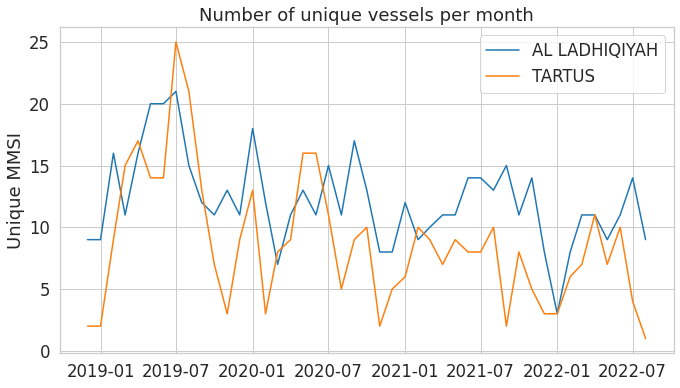

In [254]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=df_port, x="date", y='mmsi', hue="polygon_name", palette="tab10")
ax.set(xlabel="", ylabel="Unique MMSI", title="Number of unique vessels per month")
plt.legend(title='') #loc='upper right', labels=['Raw Data', 'Interpolated']
# plt.savefig("../docs/images/Output_Mining_Gas.png", facecolor='white', dpi=300)

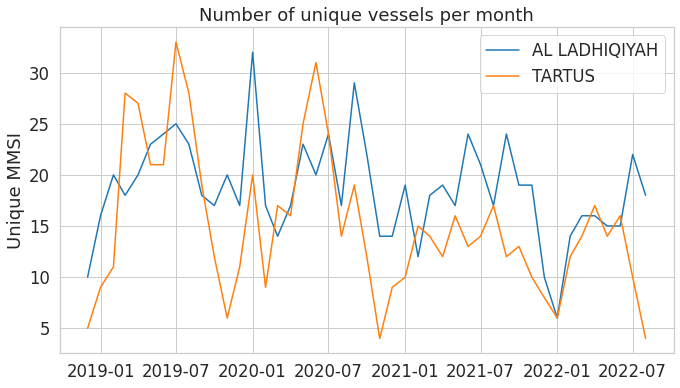

In [198]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=df_port, x="date", y='mmsi', hue="polygon_name", palette="tab10")
ax.set(xlabel="", ylabel="Unique MMSI", title="Number of unique vessels per month")
plt.legend(title='') #loc='upper right', labels=['Raw Data', 'Interpolated']
# plt.savefig("../docs/images/Output_Mining_Gas.png", facecolor='white', dpi=300)